In [1]:
from langchain_neo4j import Neo4jVector
from langchain_ollama import OllamaEmbeddings
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.ticker import FuncFormatter
import datetime
import pandas as pd

import sys
sys.path.append('/home/TomKerby/Research/lit_review/lit_review')
import utils

sys.path.append('/home/TomKerby/Research/lit_review/configs')
from rag_config import config

kg = utils.load_kg(config)

def plot_pca_comp(embeddings, color_vector, is_categorical=False):
    pca = PCA(n_components=2)
    reduced_embeddings = pca.fit_transform(embeddings)
    plt.figure(figsize=(8, 6))
    
    if is_categorical:
        categories, labels = np.unique(color_vector, return_inverse=True)
        sc = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1],
                         c=labels, cmap='tab10', alpha=0.7)
        handles = [plt.Line2D([0], [0], marker='o', color='w',
                                markerfacecolor=plt.cm.tab10(i),
                                markersize=8, label=str(cat))
                   for i, cat in enumerate(categories)]
        plt.legend(handles=handles, title='Category')
    else:
        sc = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1],
                         c=color_vector, cmap='viridis', alpha=0.7)
        plt.colorbar(sc, label='Value')
    
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.title("PCA of Abstract Embeddings")
    plt.grid(True)
    plt.show()
    
def plot_pca_comp_dates(embeddings, date_values, norm, cmap='viridis'):
    """
    embeddings: an array of high-dimensional embeddings.
    date_values: a numeric array (e.g. seconds since epoch) of the same length;
                 missing dates should be np.nan.
    norm: an instance of Normalize with vmin/vmax from valid date values.
    cmap: colormap to use for valid dates.
    """
    pca = PCA(n_components=2)
    reduced_embeddings = pca.fit_transform(embeddings)
    plt.figure(figsize=(8, 6))
    
    date_values = np.array(date_values)
    valid_mask = ~np.isnan(date_values)
    
    sc_valid = plt.scatter(
        reduced_embeddings[valid_mask, 0],
        reduced_embeddings[valid_mask, 1],
        c=date_values[valid_mask],
        cmap=cmap,
        norm=norm,
        alpha=0.7,
    )
    if not np.all(valid_mask):
        plt.scatter(
            reduced_embeddings[~valid_mask, 0],
            reduced_embeddings[~valid_mask, 1],
            color='red',
            alpha=0.7,
        )
    
    cbar = plt.colorbar(sc_valid, label='Date')
    def date_formatter(x, pos):
        try:
            dt = datetime.datetime.fromtimestamp(x)
            return dt.strftime("%Y-%m-%d")
        except Exception:
            return ""
    cbar.ax.yaxis.set_major_formatter(FuncFormatter(date_formatter))
    
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.title("PCA of Abstract Embeddings")
    plt.grid(True)
    plt.show()

In [2]:
vis_query = """
MATCH (p:Paper)
WHERE p.abstract IS NOT NULL AND p.abstract <> ''
WITH DISTINCT p, vector.similarity.cosine(p.abstractEmbedding, $embedding) AS score
ORDER BY score DESC LIMIT $k
RETURN p.abstract AS text, score, properties(p) AS metadata
"""

abstract_vector = Neo4jVector.from_existing_index(
    OllamaEmbeddings(model=config['embedding']['model_id']),
    graph=kg, 
    index_name='abstract_embeddings',
    embedding_node_property='abstractEmbedding',
    text_node_property='abstract',
    retrieval_query=vis_query,
)

# Plotting GAN vs DM papers

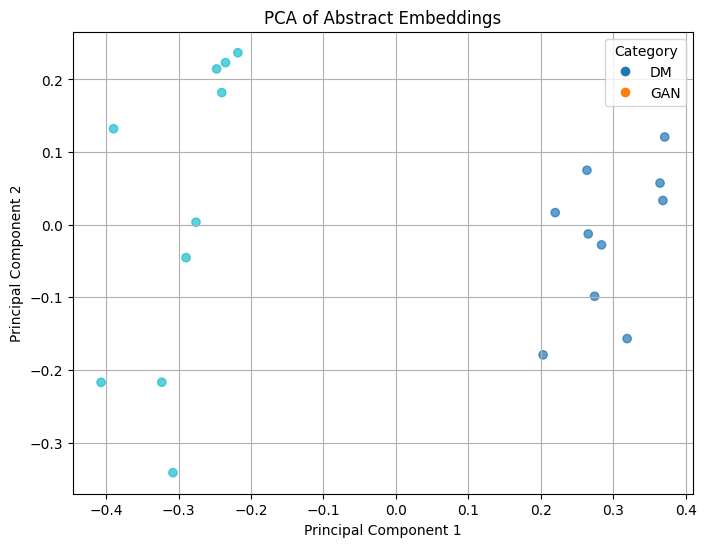

In [3]:
question = "Papers that discuss methods applied to diffusion models."
question = "search_query: " + question
retrieved_docs = abstract_vector.similarity_search_with_score(question, k=10)
diff_embeddings = np.array([doc.metadata.get("abstractEmbedding") for doc, _ in retrieved_docs])
diff_labels = ['DM'] * diff_embeddings.shape[0]

question = "Papers that discuss methods applied to GANs."
question = "search_query: " + question
retrieved_docs = abstract_vector.similarity_search_with_score(question, k=10)
gan_embeddings = np.array([doc.metadata.get("abstractEmbedding") for doc, _ in retrieved_docs])
gan_labels = ['GAN'] * gan_embeddings.shape[0]

embeddings = np.vstack([diff_embeddings, gan_embeddings])
labels = diff_labels + gan_labels

plot_pca_comp(embeddings, labels, is_categorical=True)

# Plot and color by citationCount

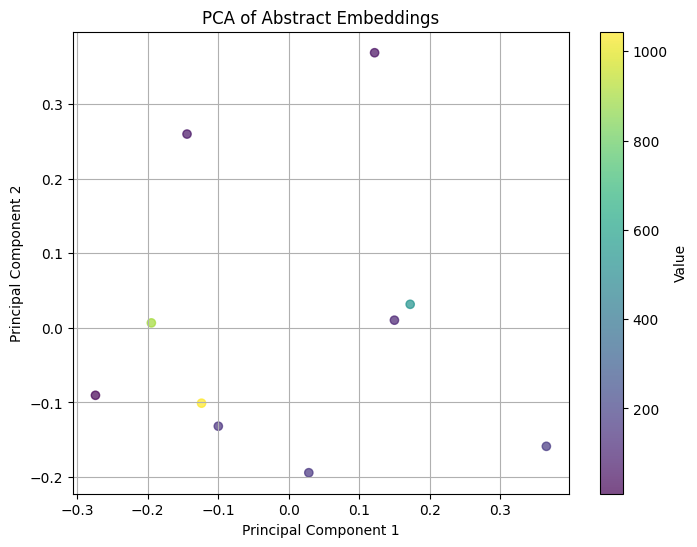

In [4]:
question = "Papers that discuss methods applied to diffusion models."
question = "search_query: " + question
retrieved_docs = abstract_vector.similarity_search_with_score(question, k=10)

embeddings = np.array([doc.metadata.get("abstractEmbedding") for doc, _ in retrieved_docs])
citation_counts = np.array([doc.metadata.get("citationCount") for doc, _ in retrieved_docs])
dates = np.array([doc.metadata.get("publicationDate") for doc, _ in retrieved_docs])

plot_pca_comp(embeddings, citation_counts, is_categorical=False)

# Plot and color by date published
Maybe should look into function for formatting date nicely

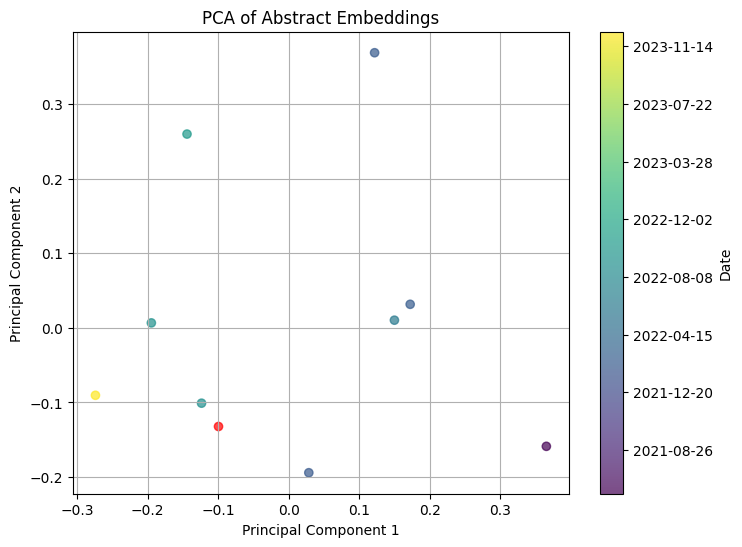

In [5]:
dates = np.array([doc.metadata.get("publicationDate") for doc, _ in retrieved_docs])
dates_series = pd.to_datetime(pd.Series(dates), format="%Y-%m-%d", errors='coerce')

date_ints = dates_series.astype('int64')
date_ints = date_ints.where(date_ints != np.iinfo('int64').min)
date_floats = date_ints / 1e9 

valid_mask = ~dates_series.isna()
vmin = date_floats[valid_mask].min()
vmax = date_floats[valid_mask].max()
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

plot_pca_comp_dates(embeddings, date_floats, norm=norm, cmap='viridis')